Polymer properties such as density, melt index, and melt flow rate must be kept within tight specifications for each grade. This project is to analyze polymer production data to predict melt flow rate.</br>
**Background**: There are gas phase and liquid slurry reactors that create polymers (polyethylene, polypropylene, polystyrene, and others) from chemical building blocks known as monomers (C2=, C3=, C4=, iC5=, and others). A catalyst is injected with the monomers under carefully controlled temperature and pressure conditions to cause a reaction that grows the polymer chains. Hydrogen is a chain transfer agent to stop the growth of the polymer chain. If the polymer chains grow too long then the polymer is too viscous for manufacturing in films, injection molding, or other applications. </br>
This case study focuses on measurements of Melt Flow Rate (MFR) to determine the polymer viscosity based on reactor conditions. An accurate model is desirable so that the infrequent lab samples (every 2-8 hours) are supplemented with a virtual and continuous "soft sensor". A model that runs in real-time simulation alongside the physical reactor is called a digital twin.</br>
Time: Timestamp of the measurements</br>
C3: Propylene (C3=) Feed Rate (kg/hr)</br>
H2R: Hydrogen to C3= Ratio</br>
Pressure: Reactor Pressure (bar)</br>
Level: Reactor Bed Level (m)</br>
C2: Ethylene (C2=) Flow (kg/hr)</br>
Cat: Catalyst Feed Rate (kg/hr)</br>
Temp: Reactor Temperature</br>
MFR: Melt Flow Rate (gm/10min)

In [ ]:
# Import Packages and Datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

full_df = pd.read_csv('https://github.com/neurogaussthm/MATH4463_CS4432_Data/raw/main/polymer_reactor.txt', names=['DateTime', 'C3', 'H2R', 'Pressure', 'Level', 'C2', 'Cat', 'Temp', 'MFR'], header=0)
full_df.dropna(inplace=True)
full_df.drop('DateTime', axis=1, inplace=True)
full_df['Log(MFR)'] = full_df['MFR'].apply(lambda x: np.log(x))

# 1. Exploratory Data Analysis and Preprocessing

In [ ]:
full_df.describe()

,C3,H2R,Pressure,Level,C2,Cat,Temp,MFR,Log(MFR)
count,2484.000000,2484.000000,2484.000000,2484.000000,2484.00000,2484.000000,2484.000000,2484.000000,2484.000000
mean,25304.758777,0.183725,30.663706,77.651055,42525.14000,0.138522,80.144365,8.036594,1.881821
std,1706.180093,0.072155,0.423345,0.919600,11331.86896,0.041885,0.823554,5.076463,0.635992
min,16106.025000,0.000000,26.946344,74.575958,9610.46480,0.022162,77.760117,1.500000,0.405465
25%,24361.490000,0.140000,30.446129,76.992151,34795.53500,0.113757,79.677458,3.700000,1.308333
50%,25364.311500,0.175000,30.622631,77.494477,41550.56250,0.132971,80.044308,4.300000,1.458615
75%,26397.439750,0.202000,30.925738,78.210867,50010.29500,0.157029,80.496296,12.800000,2.549445
max,30083.688000,0.980000,32.674332,83.841675,106073.61000,0.677979,91.566544,38.000000,3.637586


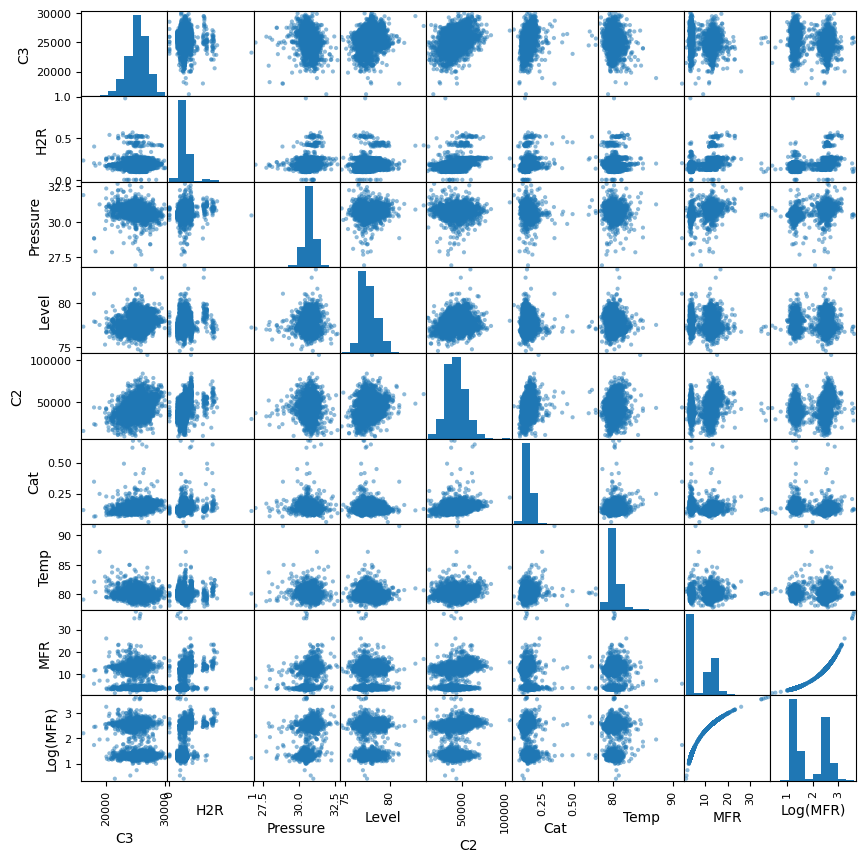

In [ ]:
pd.plotting.scatter_matrix(full_df, figsize=(10, 10))
plt.show()

In [ ]:
full_df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,C3,H2R,Pressure,Level,C2,Cat,Temp,MFR,Log(MFR)
C3,1.000000,-0.035833,-0.246382,0.207590,0.387429,0.279968,-0.157591,-0.247984,-0.258358
H2R,-0.035833,1.000000,0.221576,0.104436,0.375745,0.226919,0.052967,0.426433,0.413058
Pressure,-0.246382,0.221576,1.000000,0.044294,0.064547,-0.152372,-0.036286,0.438837,0.448031
Level,0.207590,0.104436,0.044294,1.000000,0.289986,0.000157,-0.084688,-0.006452,0.003313
C2,0.387429,0.375745,0.064547,0.289986,1.000000,0.246106,0.116090,0.233219,0.216502
Cat,0.279968,0.226919,-0.152372,0.000157,0.246106,1.000000,0.103214,-0.209013,-0.239157
Temp,-0.157591,0.052967,-0.036286,-0.084688,0.116090,0.103214,1.000000,0.125628,0.125574
MFR,-0.247984,0.426433,0.438837,-0.006452,0.233219,-0.209013,0.125628,1.000000,0.979901
Log(MFR),-0.258358,0.413058,0.448031,0.003313,0.216502,-0.239157,0.125574,0.979901,1.000000


In [ ]:
full_df.skew()

C3         -0.447849
H2R         2.645850
Pressure   -0.971380
Level       0.687793
C2          0.305661
Cat         4.818923
Temp        2.231556
MFR         0.786443
Log(MFR)    0.273851
dtype: float64

# 2. Feature Engineering/Selection

In [ ]:
full_df_log = full_df.copy()
full_df_log['H2R'].replace(to_replace=0, value=np.NaN, inplace=True)
full_df_log.dropna(inplace=True)
full_df_log['Cat'] = full_df_log['Cat'].apply(lambda x: np.log(x))
full_df_log['H2R'] = full_df_log['H2R'].apply(lambda x: np.log(x))
full_df_log['Temp'] = full_df_log['Temp'].apply(lambda x: np.log(x))
full_df_log

,C3,H2R,Pressure,Level,C2,Cat,Temp,MFR,Log(MFR)
0,24856.584,-1.877317,30.414835,79.657906,50850.578,-1.807923,4.387009,3.4,1.223775
1,25537.250,-1.877317,30.527121,78.532608,42229.813,-2.042227,4.367691,3.2,1.163151
2,25689.266,-1.877317,30.356180,78.842636,45335.852,-1.897101,4.367143,3.2,1.163151
3,25098.754,-1.877317,30.894308,79.173500,43077.016,-1.886885,4.369735,3.1,1.131402
4,24853.941,-1.897120,30.680647,78.677299,40404.387,-2.098973,4.369935,3.3,1.193922
...,...,...,...,...,...,...,...,...,...
2555,21437.066,-1.714798,31.306507,76.762871,13607.478,-2.501648,4.374771,11.8,2.468100
2556,25108.557,-1.714798,29.496073,76.608147,43186.836,-2.030402,4.405054,11.2,2.415914
2557,20050.275,-1.386294,31.061733,76.629868,31100.949,-2.361350,4.391535,11.4,2.433613
2558,21003.520,-1.687399,27.864731,77.518692,52186.004,-1.984051,4.427312,13.5,2.602690


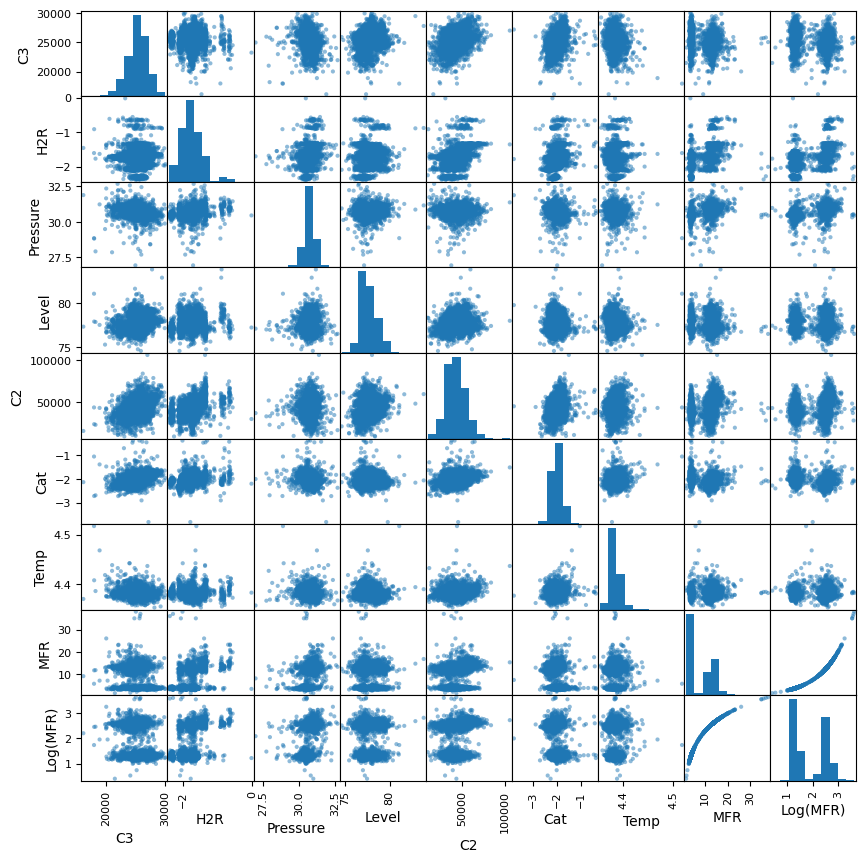

In [ ]:
pd.plotting.scatter_matrix(full_df_log, figsize=(10, 10))
plt.show()

In [ ]:
full_df_log.skew()

C3         -0.452067
H2R         0.800463
Pressure   -0.970517
Level       0.688957
C2          0.303103
Cat         0.649324
Temp        2.021535
MFR         0.790926
Log(MFR)    0.277070
dtype: float64

In [ ]:
full_df_log.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,C3,H2R,Pressure,Level,C2,Cat,Temp,MFR,Log(MFR)
C3,1.000000,-0.042067,-0.245456,0.207611,0.387677,0.361215,-0.154757,-0.247726,-0.257921
H2R,-0.042067,1.000000,0.237850,0.134239,0.415557,0.267774,0.031362,0.468434,0.461914
Pressure,-0.245456,0.237850,1.000000,0.045199,0.065343,-0.199682,-0.035169,0.437506,0.446629
Level,0.207611,0.134239,0.045199,1.000000,0.289765,0.011449,-0.089157,-0.004426,0.005238
C2,0.387677,0.415557,0.065343,0.289765,1.000000,0.303355,0.116891,0.235144,0.218319
Cat,0.361215,0.267774,-0.199682,0.011449,0.303355,1.000000,0.096378,-0.269485,-0.307658
Temp,-0.154757,0.031362,-0.035169,-0.089157,0.116891,0.096378,1.000000,0.127427,0.126865
MFR,-0.247726,0.468434,0.437506,-0.004426,0.235144,-0.269485,0.127427,1.000000,0.979854
Log(MFR),-0.257921,0.461914,0.446629,0.005238,0.218319,-0.307658,0.126865,0.979854,1.000000


In [ ]:
full_df_log.describe()

,C3,H2R,Pressure,Level,C2,Cat,Temp,MFR,Log(MFR)
count,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000
mean,25305.399873,-1.745159,30.663444,77.651625,42536.832115,-2.008984,4.383795,8.029883,1.880851
std,1706.582180,0.316816,0.423797,0.919884,11341.006025,0.246871,0.010155,5.077386,0.635992
min,16106.025000,-2.385967,26.946344,74.575958,9610.464800,-3.809386,4.353629,1.500000,0.405465
25%,24361.959000,-1.966113,30.445761,76.993553,34795.277000,-2.173272,4.378006,3.700000,1.308333
50%,25365.859000,-1.742969,30.622080,77.494667,41576.078000,-2.017072,4.382587,4.300000,1.458615
75%,26398.162000,-1.599488,30.925463,78.210709,50011.273000,-1.849744,4.388221,12.700000,2.541602
max,30083.688000,-0.020203,32.674332,83.841675,106073.610000,-0.388638,4.517066,38.000000,3.637586


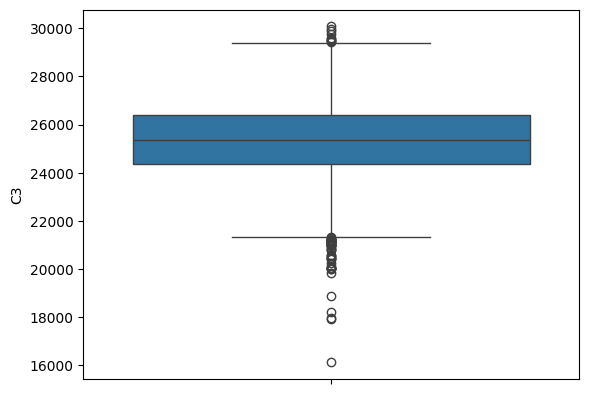

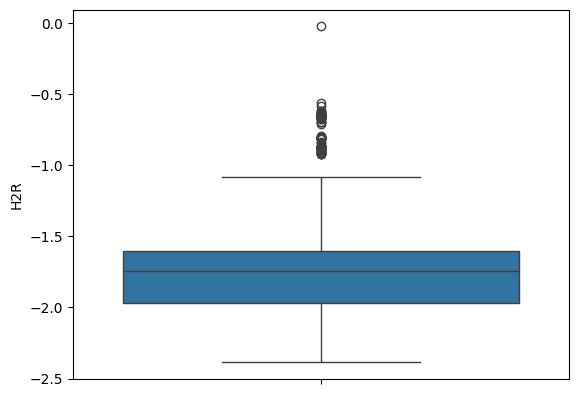

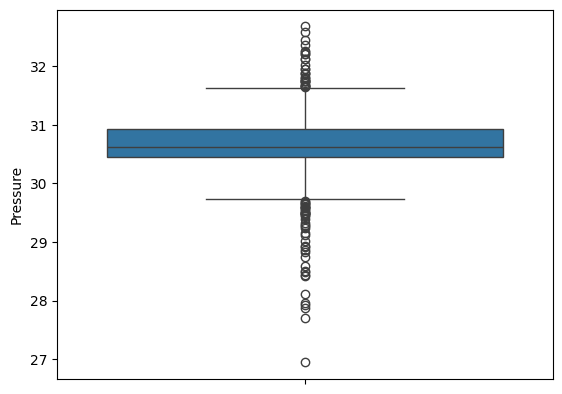

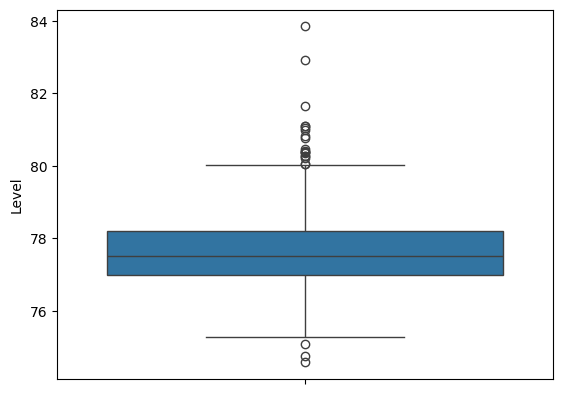

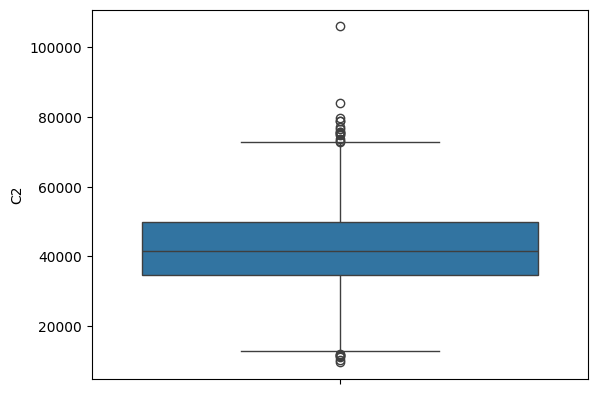

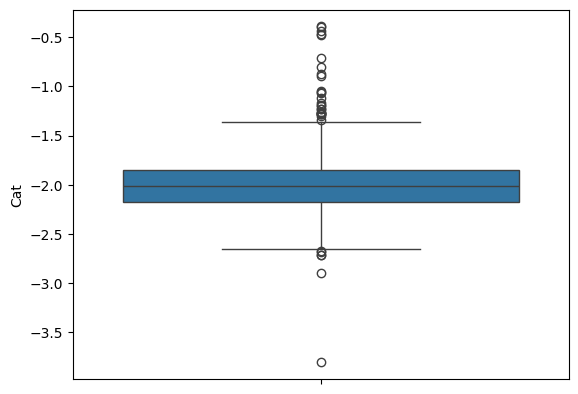

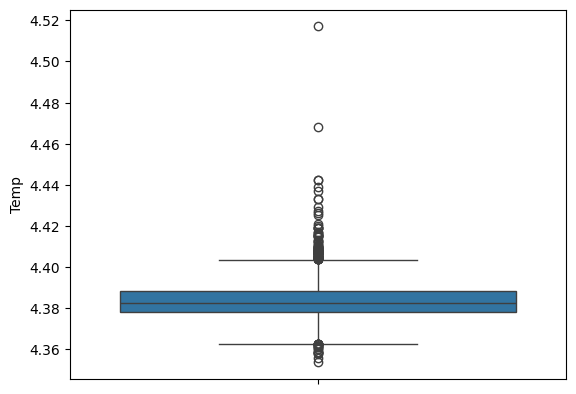

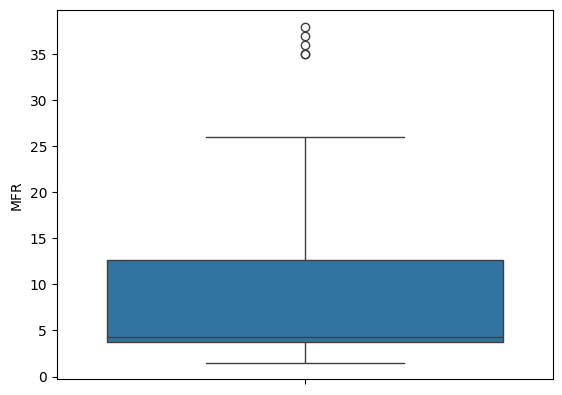

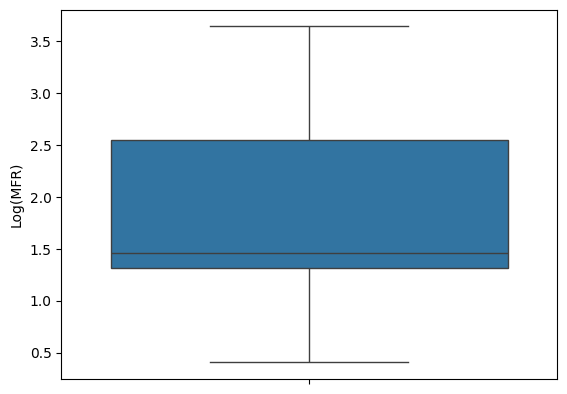

In [ ]:
for i in full_df_log:
  sns.boxplot(full_df_log[i])
  plt.show()

In [ ]:
# full_df.plot(kind = 'scatter', x = 'DateTime', y = 'MFR')
# plt.show()
# 15 sec to run

In [ ]:
# pd.DataFrame(full_df).plot.scatter(x='DateTime', y='MFR')
# 19 Sec to run

# 3. Regression Model(s)

In [ ]:
X = full_df[['C3', 'H2R', 'Pressure', 'Level', 'C2', 'Cat', 'Temp']]
X_log = full_df_log[['C3', 'H2R', 'Pressure', 'Level', 'C2', 'Cat', 'Temp']]
y_whole = full_df['MFR']
y_log_whole = full_df['Log(MFR)']
y_log = full_df_log['Log(MFR)']
y = full_df_log['MFR']

regression_full = LinearRegression().fit(X=X, y=y_whole)
print('No Logs')
print(mean_squared_error(y_whole, regression_full.predict(X), squared=False))
print(regression_full.score(X=X, y=y_whole))

regression_full_log = LinearRegression().fit(X=X, y=y_log_whole)
print('Log of MFR')
print(mean_squared_error(y_log_whole, regression_full_log.predict(X), squared=False))
print(regression_full_log.score(X=X, y=y_log_whole))

regression_full = LinearRegression().fit(X=X_log, y=y)
print('Log, no Log MFR')
print(mean_squared_error(y, regression_full.predict(X_log), squared=False))
print(regression_full.score(X=X_log, y=y))

regression_full_log = LinearRegression().fit(X=X_log, y=y_log)
print('All logs')
print(mean_squared_error(y_log, regression_full_log.predict(X_log), squared=False))
print(regression_full_log.score(X=X_log, y=y_log))

No Logs
3.8537947464143216
0.4234597278502211
Log of MFR
0.47971231790439567
0.43084068350976046
Log, no Log MFR
3.618949265555871
0.491769991238971
All logs
0.44319334769667784
0.514199266805039


# 4. Training and Testing of the Model(s)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_whole, test_size=0.2, random_state=42)
regression = LinearRegression().fit(X=X_train, y=y_train)
print(mean_squared_error(y_train, regression.predict(X_train), squared=False))
print(regression.score(X=X_train, y=y_train))
print(mean_squared_error(y_test, regression.predict(X_test), squared=False))
print(regression.score(X=X_test, y=y_test))

print('\n')
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log_whole, test_size=0.2, random_state=42)
regression_log = LinearRegression().fit(X=X_train_log, y=y_train_log)
print(mean_squared_error(y_train_log, regression_log.predict(X_train_log), squared=False))
print(regression_log.score(X=X_train_log, y=y_train_log))
print(mean_squared_error(y_test_log, regression_log.predict(X_test_log), squared=False))
print(regression_log.score(X=X_test_log, y=y_test_log))

print('\n')
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=42)
regression = LinearRegression().fit(X=X_train, y=y_train)
print(mean_squared_error(y_train, regression.predict(X_train), squared=False))
print(regression.score(X=X_train, y=y_train))
print(mean_squared_error(y_test, regression.predict(X_test), squared=False))
print(regression.score(X=X_test, y=y_test))

print('\n')
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)
regression_log = LinearRegression().fit(X=X_train_log, y=y_train_log)
print(mean_squared_error(y_train_log, regression_log.predict(X_train_log), squared=False))
print(regression_log.score(X=X_train_log, y=y_train_log))
print(mean_squared_error(y_test_log, regression_log.predict(X_test_log), squared=False))
print(regression_log.score(X=X_test_log, y=y_test_log))

3.8575574914148167
0.43252082753204724
3.8874736474985063
0.36758231297171695


0.4752630641051956
0.44320470338007323
0.5031535614334407
0.3652065001289817


3.6310567843256787
0.4880105331495659
3.582249717806978
0.5033591473532513


0.4398340636370312
0.5196134963505947
0.4580500228631837
0.4892431833125259


# 5. Evaluation and Comparison of the Models

In [ ]:
mse = 4
mse_i = 0
mse_totals = []
score = 0
score_i = 0
score_totals = []
coef_all = []
coef_avg = []
intercept = []
for i in range(10000):
  X_train, X_test, y_train, y_test = train_test_split(X, y_whole, test_size=0.2, random_state=i)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  mse_run = mean_squared_error(y_test, regression.predict(X_test), squared=False)
  mse_totals.append(mse_run)
  if mse_run < mse:
    mse = mse_run
    mse_i = i
  score_run = regression.score(X=X_test, y=y_test)
  score_totals.append(score_run)
  if score_run > score:
    score = score_run
    score_i = i
  coef_all.append(regression.coef_)
  intercept.append(regression.intercept_)
for i in range(len(X.columns)):
  sum = 0
  for j in range(len(coef_all)):
    sum += coef_all[j][i]
  coef_avg.append(sum/len(coef_all))
print(f'MSE: {mse} on run {mse_i}.')
print(f'R^2: {score} on run {score_i}.')
print(f'Average MSE: {np.sum(mse_totals)/len(mse_totals)}.')
print(f'Average R^2: {np.sum(score_totals)/len(score_totals)}.')

mse = 4
mse_i = 0
mse_totals = []
score = 0
score_i = 0
score_totals = []
coef_all = []
coef_avg = []
intercept = []
for i in range(10000):
  X_train, X_test, y_train, y_test = train_test_split(X, y_log_whole, test_size=0.2, random_state=i)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  mse_run = mean_squared_error(y_test, regression.predict(X_test), squared=False)
  mse_totals.append(mse_run)
  if mse_run < mse:
    mse = mse_run
    mse_i = i
  score_run = regression.score(X=X_test, y=y_test)
  score_totals.append(score_run)
  if score_run > score:
    score = score_run
    score_i = i
  coef_all.append(regression.coef_)
  intercept.append(regression.intercept_)
for i in range(len(X.columns)):
  sum = 0
  for j in range(len(coef_all)):
    sum += coef_all[j][i]
  coef_avg.append(sum/len(coef_all))
print(f'MSE: {mse} on run {mse_i}.')
print(f'R^2: {score} on run {score_i}.')
print(f'Average MSE: {np.sum(mse_totals)/len(mse_totals)}.')
print(f'Average R^2: {np.sum(score_totals)/len(score_totals)}.')

mse = 4
mse_i = 0
mse_totals = []
score = 0
score_i = 0
score_totals = []
coef_all = []
coef_avg = []
intercept = []
for i in range(10000):
  X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=i)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  mse_run = mean_squared_error(y_test, regression.predict(X_test), squared=False)
  mse_totals.append(mse_run)
  if mse_run < mse:
    mse = mse_run
    mse_i = i
  score_run = regression.score(X=X_test, y=y_test)
  score_totals.append(score_run)
  if score_run > score:
    score = score_run
    score_i = i
  coef_all.append(regression.coef_)
  intercept.append(regression.intercept_)
for i in range(len(X.columns)):
  sum = 0
  for j in range(len(coef_all)):
    sum += coef_all[j][i]
  coef_avg.append(sum/len(coef_all))
print(f'MSE: {mse} on run {mse_i}.')
print(f'R^2: {score} on run {score_i}.')
print(f'Average MSE: {np.sum(mse_totals)/len(mse_totals)}.')
print(f'Average R^2: {np.sum(score_totals)/len(score_totals)}.')

mse = 4
mse_i = 0
mse_totals = []
score = 0
score_i = 0
score_totals = []
coef_all = []
coef_avg = []
intercept = []
for i in range(10000):
  X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=i)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  mse_run = mean_squared_error(y_test, regression.predict(X_test), squared=False)
  mse_totals.append(mse_run)
  if mse_run < mse:
    mse = mse_run
    mse_i = i
  score_run = regression.score(X=X_test, y=y_test)
  score_totals.append(score_run)
  if score_run > score:
    score = score_run
    score_i = i
  coef_all.append(regression.coef_)
  intercept.append(regression.intercept_)
for i in range(len(X.columns)):
  sum = 0
  for j in range(len(coef_all)):
    sum += coef_all[j][i]
  coef_avg.append(sum/len(coef_all))
print(f'MSE: {mse} on run {mse_i}.')
print(f'R^2: {score} on run {score_i}.')
print(f'Average MSE: {np.sum(mse_totals)/len(mse_totals)}.')
print(f'Average R^2: {np.sum(score_totals)/len(score_totals)}.')

MSE: 3.22582806199976 on run 2688.
R^2: 0.568669131244194 on run 7164.
Average MSE: 3.874572497901548.
Average R^2: 0.41528071112830295.
MSE: 0.4249642965038477 on run 2688.
R^2: 0.542915511119273 on run 7164.
Average MSE: 0.4834189238217722.
Average R^2: 0.42029048227588867.
MSE: 2.953500835226866 on run 4743.
R^2: 0.6321743536093725 on run 8082.
Average MSE: 3.6279040798263.
Average R^2: 0.48777466592388735.
MSE: 0.38362566822859984 on run 4743.
R^2: 0.6275643742562982 on run 8082.
Average MSE: 0.44531402367310363.
Average R^2: 0.5082324750030897.


In [ ]:
# Try removing each variable from the set tested
print('No Logs')
for i in X:
  X_new = X.drop(i, axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_new, y_whole, test_size=0.2, random_state=42)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  print(i)
  print('Training:')
  print(mean_squared_error(y_train, regression.predict(X_train), squared=False))
  print(regression.score(X=X_train, y=y_train))
  print('Testing:')
  print(mean_squared_error(y_test, regression.predict(X_test), squared=False))
  print(regression.score(X=X_test, y=y_test))

print('\ny log')
for i in X:
  X_new = X.drop(i, axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_new, y_log_whole, test_size=0.2, random_state=42)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  print(i)
  print('Training:')
  print(mean_squared_error(y_train, regression.predict(X_train), squared=False))
  print(regression.score(X=X_train, y=y_train))
  print('Testing:')
  print(mean_squared_error(y_test, regression.predict(X_test), squared=False))
  print(regression.score(X=X_test, y=y_test))

print('\nx logs')
for i in X_log:
  X_new = X_log.drop(i, axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  print(i)
  print('Training:')
  print(mean_squared_error(y_train, regression.predict(X_train), squared=False))
  print(regression.score(X=X_train, y=y_train))
  print('Testing:')
  print(mean_squared_error(y_test, regression.predict(X_test), squared=False))
  print(regression.score(X=X_test, y=y_test))

print('\nAllLogs')
for i in X_log:
  X_new = X_log.drop(i, axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_new, y_log, test_size=0.2, random_state=42)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  print(i)
  print('Training:')
  print(mean_squared_error(y_train, regression.predict(X_train), squared=False))
  print(regression.score(X=X_train, y=y_train))
  print('Testing:')
  print(mean_squared_error(y_test, regression.predict(X_test), squared=False))
  print(regression.score(X=X_test, y=y_test))

No Logs
C3
Training:
3.907934374919571
0.41760231998865016
Testing:
3.9370637011760032
0.3513446943158317
H2R
Training:
4.194348092675937
0.329105776860516
Testing:
3.9013917716635627
0.3630457807712264
Pressure
Training:
4.047817414034421
0.3751627087947208
Testing:
4.1949386195864
0.263588922767899
Level
Training:
3.8815006234647935
0.42545449321249507
Testing:
3.8856041003920336
0.3681904458942269
C2
Training:
3.9488934032243588
0.405330132243797
Testing:
4.04724742460179
0.3145297635925536
Cat
Training:
4.085089268845106
0.363602866559818
Testing:
3.897935336714522
0.3641738989937753
Temp
Training:
3.884934600066697
0.42443743884735297
Testing:
3.896095568402393
0.36477395854009875

y log
C3
Training:
0.48152647890364386
0.4284321684706872
Testing:
0.5089819023717103
0.35041490674537523
H2R
Training:
0.5165443519912731
0.3422775510109769
Testing:
0.5059697446042865
0.3580806529499284
Pressure
Training:
0.5001308831005309
0.38341241369635426
Testing:
0.5446672261610981
0.25613546053

In [ ]:
# Drop Level

mse1 = 4
mse_i1 = 0
mse_totals1 = []
score1 = 0
score_i1 = 0
score_totals1 = []
coef_all1 = []
coef_avg1 = []
intercept1 = []
for i in range(10000):
  X_train, X_test, y_train, y_test = train_test_split(X.drop('Level', axis=1), y, test_size=0.2, random_state=i)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  mse_run = mean_squared_error(y_test, regression.predict(X_test), squared=False)
  mse_totals1.append(mse_run)
  if mse_run < mse1:
    mse1 = mse_run
    mse_i1 = i
  score_run = regression.score(X=X_test, y=y_test)
  score_totals1.append(score_run)
  if score_run > score1:
    score1 = score_run
    score_i1 = i
  coef_all1.append(regression.coef_)
  intercept1.append(regression.intercept_)

print(f'MSE: {mse1} on run {mse_i1}.')
print(f'R^2: {score1} on run {score_i1}.')
print(f'Average MSE: {np.sum(mse_totals1)/len(mse_totals1)}.')
print(f'Average R^2: {np.sum(score_totals1)/len(score_totals1)}.')

MSE: 3.251358552328249 on run 1593.
R^2: 0.5582307895126248 on run 7164.
Average MSE: 3.891712281146934.
Average R^2: 0.4101210277276943.


In [ ]:
# Drop Level on two best models
mse = 4
mse_i = 0
mse_totals = []
score = 0
score_i = 0
score_totals = []
coef_all = []
coef_avg = []
intercept = []
for i in range(100):
  X_train, X_test, y_train, y_test = train_test_split(X_log.drop('Level', axis=1), y, test_size=0.2, random_state=i)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  mse_run = mean_squared_error(y_test, regression.predict(X_test), squared=False)
  mse_totals.append(mse_run)
  if mse_run < mse:
    mse = mse_run
    mse_i = i
  score_run = regression.score(X=X_test, y=y_test)
  score_totals.append(score_run)
  if score_run > score:
    score = score_run
    score_i = i

print(f'MSE: {mse} on run {mse_i}.')
print(f'R^2: {score} on run {score_i}.')
print(f'Average MSE: {np.sum(mse_totals)/len(mse_totals)}.')
print(f'Average R^2: {np.sum(score_totals)/len(score_totals)}.')

mse = 4
mse_i = 0
mse_totals = []
score = 0
score_i = 0
score_totals = []
coef_all = []
coef_avg = []
intercept = []
for i in range(100):
  X_train, X_test, y_train, y_test = train_test_split(X_log.drop('Level', axis=1), y_log, test_size=0.2, random_state=i)
  regression = LinearRegression().fit(X=X_train, y=y_train)
  mse_run = mean_squared_error(y_test, regression.predict(X_test), squared=False)
  mse_totals.append(mse_run)
  if mse_run < mse:
    mse = mse_run
    mse_i = i
  score_run = regression.score(X=X_test, y=y_test)
  score_totals.append(score_run)
  if score_run > score:
    score = score_run
    score_i = i

print(f'MSE: {mse} on run {mse_i}.')
print(f'R^2: {score} on run {score_i}.')
print(f'Average MSE: {np.sum(mse_totals)/len(mse_totals)}.')
print(f'Average R^2: {np.sum(score_totals)/len(score_totals)}.')

MSE: 3.150044109695129 on run 61.
R^2: 0.5831059238805613 on run 61.
Average MSE: 3.639069287149177.
Average R^2: 0.48402668312868874.
MSE: 0.4043569581033502 on run 51.
R^2: 0.5836011216941517 on run 51.
Average MSE: 0.4466441388160986.
Average R^2: 0.5051695302213688.
